In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
import quandl
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression

quandl.ApiConfig.api_key = "N4qqCNiLHGzJxUKQJMv3"

style.use('ggplot')

In [2]:
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close'])/df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open'])/df['Adj. Open'] * 100
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [3]:
forecast_col = 'Adj. Close'
df.fillna(-9999, inplace = True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace = True)
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  69.078238
2004-08-20   54.322689  0.710922    7.227007   22834300.0  67.839414
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  1.886792    1.183658    9188600.0  71.219849


In [4]:
X = np.array(df.drop(['label'], 1))
X_lately = X[-forecast_out :]
X = preprocessing.scale(X)
df.dropna(inplace = True)
y = np.array(df['label'])
print(len(X), len(y))

3389 3389


In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

In [6]:
clf = LinearRegression(n_jobs = -1)
clf.fit(X_train, y_train)
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)
accuracy = clf.score(X_test, y_test)

In [7]:
print(accuracy)

0.9772237060825472


In [8]:
forecast_set = clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out)

[ -4599549.46849623  -9518546.89177654  -4437734.04982312
  -3819978.12344588  -4269903.14487598  -3577822.29031688
  -2465532.0593483   -2637155.9439706   -2997825.30803531
  -2854800.43755303  -3408552.41725056  -4672813.08441265
  -4651627.4780476   -3820284.29449331  -4465134.72072541
  -3369725.29695562  -3964388.91321745  -2985712.89337798
  -3222568.6703974   -5797950.47229888  -5383027.07717171
  -4012102.68060885  -3951044.96309882  -4218417.0817876
  -4275422.40596876  -5524870.00011786  -5481793.39559856
  -4146993.69648107  -5996557.11016247  -4574765.61493981
  -5398981.7832937   -4925188.95535034  -8519362.24264205
 -18143496.53996083 -11622002.9777782 ] 0.9772237060825472 35


In [9]:
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
oneday = 86400
next_unix = last_unix + oneday

In [10]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix  = next_unix + oneday
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] +[i]
    

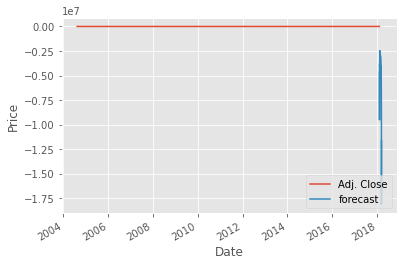

In [11]:
df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()